# 1. Data preprocessing
## import lib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

## 1) load data and remove duplicated data


In [2]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')

In [30]:
data.head

<bound method NDFrame.head of           Sentence #           Word  POS Tag
0        Sentence: 1      Thousands  NNS   O
1                NaN             of   IN   O
2                NaN  demonstrators  NNS   O
3                NaN           have  VBP   O
4                NaN        marched  VBN   O
...              ...            ...  ...  ..
1048570          NaN           they  PRP   O
1048571          NaN      responded  VBD   O
1048572          NaN             to   TO   O
1048573          NaN            the   DT   O
1048574          NaN         attack   NN   O

[1048575 rows x 4 columns]>

In [31]:
print(f' # of rows : {len(data)}')
print(f' null in datas : {data.isnull().values.any()}')

 # of rows : 1048575
 null in datas : True


In [32]:
print(f'# null in data')
print('-'*20)
print(data.isnull().sum())

# null in data
--------------------
Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64


In [33]:
print(f'rm duplicated data[\'sencence\'] : {data["Sentence #"].nunique()}')
print(f'rm duplicated data[\'Word\'] : {data.Word.nunique()}')
print(f'rm duplicated data[\'Tag\'] : {data.Tag.nunique()}')

rm duplicated data['sencence'] : 47959
rm duplicated data['Word'] : 35178
rm duplicated data['Tag'] : 17


BIO 표현 방법에서 아무런 태깅도 의미하지 않는 O가 가장 887,908개로 가장 많은 개수를 차지함을 볼 수 있습니다.

In [34]:
print('Tag count table')
print('-'*20)
print(data.groupby('Tag').size().reset_index(name='count'))
# groupby object unpacking
#for i in data.groupby('Tag'):
#  print(i)

Tag count table
--------------------
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


- fillna(method='ffill')을 활용하여 null 값을 가진 바로 이전행의 값으로 초기화
  * ffill : front fill로 추정

In [4]:
data = data.fillna(method='ffill')
print(data[-5:-1])
print(data.isnull().any())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
Sentence #    False
Word          False
POS           False
Tag           False
dtype: bool


- 대문자->소문자(문자의 갯수를 줄이기 위함, 어차피 같은 뜻이기도 함)

In [5]:
print(f'before upper to lower, rm duplicated of data[\'Word\'] : {data.Word.nunique()}')
data['Word'] = data['Word'].str.lower()
print(f'after upper to lower, rm duplicated of data[\'Word\'] : {data.Word.nunique()}')
data[-6:-1]

before upper to lower, rm duplicated of data['Word'] : 35178
after upper to lower, rm duplicated of data['Word'] : 31817


,Sentence #,Word,POS,Tag
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


## 2) transform tagging infos to integer incoding, EDA

- 문장에 등장한 단어와 Tag 정보끼리 페어링

In [71]:
lambda_func = lambda temp: [(w,t) for w,t in zip(temp['Word'].values.tolist(), temp['Tag'].values.tolist())]

print(f'before total sample count : {data.isnull().sum()["Sentence #"]}') # 1000616
tagged_sentences = [t for t in data.groupby('Sentence #').apply(lambda_func)]
print(f'after total sample count : {len(tagged_sentences)}')
print(f'sample : {tagged_sentences[0]}')

before total sample count : 0
after total sample count : 47959
sample : [('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


- 학습을 시키기 위해 단어와 tag 정보 분리

In [72]:
sentences, ner_tags = list(), list()

for tagged_sentence in tagged_sentences:

  s, t = zip(*tagged_sentence)
  #unpacking item type == tuple
  #Tokenizer.fit_on_text 내부에서 lower() 수행하기 때문에 tuple로 들어가면 안됨
  sentences.append(list(s))
  ner_tags.append(list(t))

- 전체 데이터의 문장 길이 분포 확인
  - 0에서 40 사이로 분포하고 있음

longest sentence len: 104
mean sentence len: 21.863987989741236


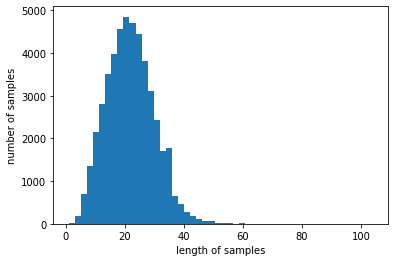

In [73]:
print(f'longest sentence len: {max(len(s) for s in sentences)}')
print(f'mean sentence len: {sum(map(len, sentences))/len(sentences)}')
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- keras tokenizer 를 활용한 정수 인코딩

In [74]:
# 모든 단어 사용, idx[1] = OOV
src_tokenizer = Tokenizer(oov_token="OOV")
src_tokenizer.fit_on_texts(sentences)
# tag 정보 대문자 유지
tar_tokenizer = Tokenizer(lower=False)
tar_tokenizer.fit_on_texts(ner_tags)

vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print(f'word_vocab len : {vocab_size}\ntag_vocab len : {tag_size}')
print(f'idx of OOV : {src_tokenizer.word_index["OOV"]}')

word_vocab len : 31819
tag_vocab len : 18
idx of OOV : 1


- 정수 인코딩 진행

In [75]:
X_data = src_tokenizer.texts_to_sequences(sentences)
Y_data = tar_tokenizer.texts_to_sequences(ner_tags)

print(X_data[0])
print(Y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


- 모델 훈련 후, 결과 확인을 위한 변수 지정
  - index_to_word : 인덱스로부터 단어 리턴
  - index_to_ner : 인덱스로부터 tag 리턴

In [76]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word

ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = "PAD"

index_to_ner

{0: 'PAD',
 1: 'O',
 2: 'B-geo',
 3: 'B-tim',
 4: 'B-org',
 5: 'I-per',
 6: 'B-per',
 7: 'I-org',
 8: 'B-gpe',
 9: 'I-geo',
 10: 'I-tim',
 11: 'B-art',
 12: 'B-eve',
 13: 'I-art',
 14: 'I-eve',
 15: 'B-nat',
 16: 'I-gpe',
 17: 'I-nat'}

## 3) 문자 임베딩을 위한 preprocessing

- 문자와 매핑된 정수를 각각 임베딩 층을 거치도록 하여, 문자 단위의 임베딩을 얻어낸다
  - 전체 데이터의 모든 단어를 문자 레벨로 분해 -> 문자 집합 생성

In [55]:
words = list(set(data['Word'].values))
chars = set([char for word in words for char in word])
chars = sorted(list(chars))
print('char set elements')
print('-'*50)
for i in range(len(chars)//9):
  print(chars[i*9:i*9+9])

char set elements
--------------------------------------------------
['!', '"', '#', '$', '%', '&', "'", '(', ')']
['+', ',', '-', '.', '/', '0', '1', '2', '3']
['4', '5', '6', '7', '8', '9', ':', ';', '?']
['@', '[', ']', '_', '`', 'a', 'b', 'c', 'd']
['e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']
['n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v']
['w', 'x', 'y', 'z', '~', '\x85', '\x91', '\x92', '\x93']
['\x94', '\x96', '\x97', '\xa0', '°', 'é', 'ë', 'ö', 'ü']


- 딕셔너리 생성
  - char to index
  - index to char

In [56]:
char_to_idx = {val : idx+2 for idx,val in enumerate(chars)}
char_to_idx["OOV"] = 1
char_to_idx["PAD"] = 0

idx_to_char = {}
for k,v in char_to_idx.items():
  idx_to_char[v] = k

- 문자의 최대 길이를 15로 제한한 후, 그 미만의 문장 패딩 추가
  - post padding 하는 이유?

In [35]:
max_len_sentence = 15

def padding_char_indice(char_indice:list, max_len_sentence:int):
  return pad_sequences(char_indice, maxlen=max_len_sentence, padding='post', value=0)

# word to sequence and padding
def integer_coding(sentences):
  char_data = []
  for sentence in sentences:
    word_indice = [word_to_index[word] for word in sentence]
    char_indice = [[char_to_idx[char] for char in word] for word in sentence]
    char_indice = padding_char_indice(char_indice, max_len_sentence)

    for char_token in char_indice:
      if len(char_token) > max_len_sentence:
        continue
    char_data.append(char_indice)
  return char_data

X_char_data = integer_coding(sentences)

In [43]:
print('before\tafter')
for bef, af in zip(sentences[0], X_data[0]):
  print(f'{bef}\t{af}')

before	after
thousands	254
of	6
demonstrators	967
have	16
marched	1795
through	238
london	468
to	7
protest	523
the	2
war	129
in	5
iraq	61
and	9
demand	571
the	2
withdrawal	833
of	6
british	186
troops	90
from	22
that	15
country	56
.	3


## 4) Data split

- max_len(70) 만큼 패딩 진행 및 train/test set 분리

In [63]:
max_len = 70
# padding to sequence
X_data = pad_sequences(X_data, maxlen=max_len, padding='post', value=0)
Y_data = pad_sequences(Y_data, maxlen=max_len, padding='post', value=0)
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value=0)

In [68]:
#split train/test data
X_train, X_test, Y_train_int, Y_test_int = train_test_split(X_data, Y_data, test_size=.2, random_state=777)
X_char_train, X_char_test, _, _ = train_test_split(X_char_data, Y_data, test_size=.2, random_state=777)

X_char_train = np.array(X_char_train)
X_char_test = np.array(X_char_test)

In [69]:
#one-hot encoding to tag info
Y_train = to_categorical(Y_train_int, num_classes=tag_size)
Y_test = to_categorical(Y_test_int, num_classes=tag_size)

In [66]:
print(f'first word of sentence\' 150th : {index_to_word[150]}')

for col in X_char_train[0]:
  for idx in col:
    if idx != 0:
      print(idx_to_char[idx], end='')
  print(end=' ')

first word of sentence' 150th : soldiers
soldiers returned fire with artillery and machine guns and a gun battle broke out .                                                        

- 각 데이터와 레이블의 크기 확인

In [70]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(Y_train.shape))
print('훈련 샘플 char 데이터의 크기 : {}'.format(X_char_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(Y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
훈련 샘플 char 데이터의 크기 : (38367, 70, 15)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


# 2. BiLSTM-CNN을 이용한 개체명 인식